In [6]:
import numpy as np
import numpy.random
import numpy.matlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd # Pandas library
import numpy as np # Numpy library
import matplotlib.pyplot as plt # Matplotlib library
import numpy.linalg as la # Linear algebra functions
import math # Math library
import random # Random library
import seaborn as sns # Seaborn library

In [7]:


"""
A "from-scratch" neural network implementation for educational purposes.
This version is a simple binary classififer. It allows the user to incrementally
train the network, displaying the resulting decision boundary and full density.
The training data is hard-coded, but there is also a loop to allow more
custom training data. We initialize the weights to be drawn from a standard
Gaussian distribution.

A crude diagram of a NN with two hidden layers and 2-dimensional inputs.
The final layer is returned as a weighted sum, passed through a final
sigmoid function. This scalar will determine which class to assign to the
input point.

x1--O---O
  \ / \ / \ 
   x   x   O --
  / \ / \ /
x2--O---O

@author: Joseph Anderson <jtanderson@salisbury.edu>
@date:   28 May 2019

Exercise 1: vectorize more of the operations, combine the input, output, and
hidden layers into single matrices. 
Exercise 2: Adapt the model to learn more than two classes
Exercise 3: Use "convolutional" or "recurrent" neuron architectures
Exercise 4: Turn into a "generative" model, to generate typical examples
from either of the two classes
Exercise 5: Parallelize!


For motivation/explanation, see, for example:
https://google-developers.appspot.com/machine-learning/crash-course/backprop-scroll/
"""

# The dimensionality of the input data
dim = 2 

# The number of hidden layers
num_layers = 1

# The size of each hidden layer
layer_size = 2

# The step size used in gradient descent
rate = 0.1

bias = False

# add a dimension for bias
if bias:
    dim += 1

# X holds N-by-d samples
#   - N is number of samples
#   - d is dimension
X = np.empty((0,dim), float)

# Y holds N labels of -1 or 1
Y = np.array([])

# input weights. Row i is the array of weights applied to x_i
w_in = np.random.standard_normal((dim,layer_size))

# "Tensor" (3-dim array) of hidden-layer output weights. 
# w_hidden[lay][i][j] is the weight between lay node i and lay+1 node j
w_hidden = np.random.standard_normal((num_layers-1, layer_size, layer_size))

# output weights, comes from last layer
w_out = np.random.standard_normal((1,layer_size))

# Use the standard sigmoid function. Another option is arctan, etc.
def sigmoid(arr):
    return 1/(1+np.exp(-1*arr))

# The derivative of the sigmoid function.
# Check this by hand to see how convenient it is :)
def sigmoid_deriv(arr):
    return sigmoid(arr) * (1 - sigmoid(arr))

# The squared error between to vectors/scalars
def msqerr(pred, ans):
    return np.sum((pred-ans)**2)/2

def reset():
    w_in = np.random.standard_normal((dim,layer_size))
    w_hidden = np.random.standard_normal((num_layers-1, layer_size, layer_size))
    w_out = np.random.standard_normal((1,layer_size))
    return (w_in, w_hidden, w_out)

In [8]:
"""
forward_step takes the weights of the network and an input point,
returning the scalar output of the network, along with a matrix
which is a record of the output of each intermediate node during
the computation. This is needed for training and verification.

Arguments:
inw is the dim-by-h matrix of input weights to the first layer
outw is the h-by-1 array of weights from the last hidden layer to the output node
hiddenw is the num_layers-by-layer_size-by-layer_size matrix of weights between each layer
    hidden[i] has the weights from i to i+1
    hidden[i][j] is the array of weights into node j of layer i+1
data is 1-by-dim row vector

Returns:
scalar value coming out of the output node
outs is layers-by-layer_size to store the output of each node
"""
def forward_step(inw, outw, hiddenw, data):
    outs = np.array([sigmoid(data @ inw)]) # 1-by-dim times dim-by-h
    for i in range(1,num_layers):
        # i-1 here because w[i] is output weights
        # get the output of the last layer (sig of x) and weight it into this layer
        ins = outs[-1] @ hiddenw[i-1]  # 1-by-h times h-by-h
        outs = np.append(outs, [sigmoid(ins)], axis=0)

    # last row of outs now holds the weighted output of the last hidden layer
    ret = sigmoid(outs[-1] @ outw.T)
    return ret[0], outs

"""
backprop analyzes how wrong the network was at predicting a given label,
then uses the magnitude of the error to perform gradient descent on the
edge weights throughout the network. Check this with the chain rule
of the error function! It tracks the change in error with respect to weights,
inputs, and outputs of every node in the network

inw: dim-by-layer_size
    weights of the input nodes
outw: 1-by-layer_size
    weights to the output node
hiddenw: num_layers-1 x layer_size x layer_size
    hiddenw[lay][i][j] is the weight between lay node i and lay+1 node j
    a column is all input weights to that node
outputs: num_layers x layer_size
    record of every node's output from the forward pass
pred: scalar predicted output
data: the input data point
label: scalar true output
"""
def backprop(inw, outw, hiddenw, outputs, pred, data, label):
    dEyo = pred - label # scalar
    dExo = dEyo * sigmoid_deriv(np.dot(outputs[-1], outw[0])) # scalar
    dEwo =  dExo * outputs[-1] #np.zeros((1, layer_size)) # out
    
    # hidden layer derivatives setup
    dEwh = np.zeros((num_layers-1, layer_size, layer_size))
    dExh = np.zeros((num_layers, layer_size))
    dEyh = np.zeros((num_layers, layer_size))
    
    # need to do output layer first, not a matrix product
    dEyh[-1] = outw * dExo # 1-by-h times scalar

    for i in range(num_layers-2,-1,-1):
        # i-1 to get the inputs to layer i
        x = outputs[i-1] @ hiddenw[i-1] # 1-by-h times h-by-h
        dExh[i] = dEyh[i] * sigmoid_deriv(x) # 1-by-h
        dEwh[i] = outputs[i-1] * dExh[i]
        if i > 0:
            # prep the next layer
            dEyh[i-1] = hiddenw[i] @ dExh[i].T # h-by-h times h-by-1

    #dEwi = outputs[0] * dEyh[0] # take care of the input layer, again
                                # not a matrix product
    data = numpy.array([data])
    dEwi = np.matlib.repmat(data.T, 1, layer_size) * np.matlib.repmat(dExh[0], dim, 1)  # dim-by-h broadcast dim-by-h


    # adjust the hiden layer weights accoriding to the error.
    # Check to see that this follows gradient descent!
    hiddenw = hiddenw - rate * dEwh
    inw = inw - rate * dEwi
    outw[0] = outw[0] - rate * dEwo

    # return the new weights
    return inw, outw, hiddenw

In [28]:
def train_rounds(train_x, train_y, num_rounds, w_in, w_out, w_hidden):    
    # iterate as long as we're told
    # For each epoch, it would be helpful to print the total "loss" -- the error
    # across the whole training set.
    # Often, one might choose a loss threshold (say, < 0.0001) and simply train until
    # the loss is smaller
    for i in range(1,num_rounds+1):
        # iterate each data point
        loss = 0
        for j in range(0,train_x.shape[0]):
            dat = train_x[j]
            if bias:
                dat = np.append(train_x[j], [1])

            # get the prediction for the point, using the current weights (model)
            pred, vals = forward_step(w_in, w_out, w_hidden, dat)
            # adjust the weights (model) to account for whether we're incorrect
            w_in, w_out, w_hidden = backprop(w_in, w_out, w_hidden, vals, pred, dat, train_y[j])
            loss += abs(pred - train_y[j])**2
    print("Current loss: " + str(loss))

    return (w_in, w_out, w_hidden)

In [40]:
crime_data = pd.read_csv('./SanFranciscoCrimeDataset/crime.csv',
                          header=1,
                          skipinitialspace=False,
                          names=['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time',
                                'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId'])
crime_data = crime_data[ ~crime_data['PdDistrict'].isna() ]

#Time
crime_data_timeMin = [((int(i.split(':')[0])*60) + int(i.split(':')[1])) for i in crime_data['Time']]
crime_data['Time in Min'] = crime_data_timeMin

#Date
crime_data_date = [i.split()[0] for i in crime_data['Date']]
crime_data_dateDays = [ ((int(i.split('/')[0])-1)*30.4167) + (int(i.split('/')[1])) for i in crime_data_date]
crime_data['Date in Days'] = crime_data_dateDays

#PD District
District_Parse = list(set([i[0] for i in crime_data[['PdDistrict']].values]))
crime_district_mapping = {crime: ind for ind, crime in enumerate(District_Parse)}
crime_data_District = [crime_district_mapping[row[1][0]] for row in crime_data[['PdDistrict']].iterrows()]

crime_data['One Hot Encoding PdDist'] = crime_data_District

#Day of week
Day_Parse = list(set([i[0] for i in crime_data[['DayOfWeek']].values]))
crime_days_mapping = {crime: ind for ind, crime in enumerate(Day_Parse)}
crime_data_Days = [crime_days_mapping[row[1][0]] for row in crime_data[['DayOfWeek']].iterrows()]

crime_data['One Hot Encoding DayOfWeek'] = crime_data_Days
print("Done")

Done


In [42]:
crime_data.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,Time in Min,Date in Days,One Hot Encoding PdDist,One Hot Encoding DayOfWeek
0,120058272,WEAPON LAWS,"FIREARM, LOADED, IN VEHICLE, POSSESSION OR USE",Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212168,660,29.0000,7,6
1,141059263,WARRANTS,WARRANT ARREST,Monday,04/25/2016 12:00:00 AM,14:59,BAYVIEW,"ARREST, BOOKED",KEITH ST / SHAFTER AV,-122.388856,37.729981,"(37.7299809672996, -122.388856204292)",14105926363010,899,116.2501,2,5
2,160013662,NON-CRIMINAL,LOST PROPERTY,Tuesday,01/05/2016 12:00:00 AM,23:50,TENDERLOIN,NONE,JONES ST / OFARRELL ST,-122.412971,37.785788,"(37.7857883766888, -122.412970537591)",16001366271000,1430,5.0000,3,3
3,160002740,NON-CRIMINAL,LOST PROPERTY,Friday,01/01/2016 12:00:00 AM,00:30,MISSION,NONE,16TH ST / MISSION ST,-122.419672,37.765050,"(37.7650501214668, -122.419671780296)",16000274071000,30,1.0000,5,6
4,160002869,ASSAULT,BATTERY,Friday,01/01/2016 12:00:00 AM,21:35,NORTHERN,NONE,1700 Block of BUSH ST,-122.426077,37.788019,"(37.788018555829, -122.426077177375)",16000286904134,1295,1.0000,9,6


In [44]:
"""
Hard-code more points, or adjuslist([0, 0, 0, 0, 0, 0, 0, 1, 0, 0]t as needed.
Check to make sure the structure matches the assumptions above
"""

# Input data, linearly separable classes
# Even for this setup, the network can have a tough time getting a good model!
# Sometimes you can even hit a "local" minimum where more training doesn't help,
# we need to perturb things a bit or get more data.
X = crime_data[['X', 'Y', 'Time in Min', 'Date in Days', 'One Hot Encoding PdDist', 'One Hot Encoding DayOfWeek']].values
print(X)
# The labels
parse_crimes = list(set([i[0] for i in crime_data[['Category']].values]))
crime_mapping = {crime: ind for ind, crime in enumerate(parse_crimes)}

Y = [crime_mapping[row[1][0]] for row in crime_data[['Category']].iterrows()]
"""
Y = [[0 if crime_data[''].index(d)!=i else 1 for (i,p) in enumerate(Day_Parse)] for d in crime_data[['DayOfWeek']].values]

epochs = 1000Y = [[crime_mapping[row

# To run and get updated weights:list([0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
# w_in, w_out, w_hidden = train_rounds(X, Y, epochs, w_in, w_out, w_hidden)
"""

[[ -122.40340479    37.77542071   660.            29.             7.             6.        ]
 [ -122.3888562     37.72998097   899.           116.2501         2.             5.        ]
 [ -122.41297054    37.78578838  1430.             5.             3.             3.        ]
 ..., 
 [ -122.41226909    37.79067276  1200.           363.5837         6.             4.        ]
 [ -122.40665871    37.78827453   600.           364.5837         6.             6.        ]
 [ -122.40340479    37.77542071   840.           336.5837         7.             6.        ]]


"\nY = [[0 if crime_data[''].index(d)!=i else 1 for (i,p) in enumerate(Day_Parse)] for d in crime_data[['DayOfWeek']].values]\n\nepochs = 1000Y = [[crime_mapping[row\n\n# To run and get updated weights:list([0, 0, 0, 0, 0, 0, 0, 1, 0, 0]\n# w_in, w_out, w_hidden = train_rounds(X, Y, epochs, w_in, w_out, w_hidden)\n"

In [45]:
w_in, w_hidden, w_out = reset()

In [46]:
w_in, w_out, w_hidden = train_rounds(X, Y, 1, w_in, w_out, w_hidden)

ValueError: shapes (6,) and (2,2) not aligned: 6 (dim 0) != 2 (dim 0)

Current loss: 2.96781358041


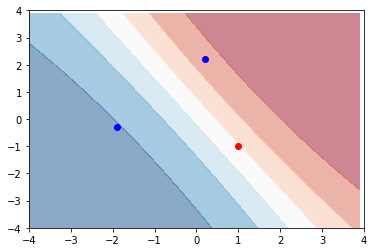

In [54]:
w_in, w_out, w_hidden = train_rounds(X, Y, 1, w_in, w_out, w_hidden)